In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import pickle 

data = pd.read_csv("../data/processed/output.csv")

def build_labels():
    print("Building label targets...")
    labels = to_categorical(data["LABEL"], num_classes=4)
    return labels

n_most_common_words = 8000
def build_tokens():
    
    print("Building features...")
    max_len = 130
    
    print("Building token features...")
    tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(data["contenu"].values)
    
    print("Building sequence features...")
    sequences = tokenizer.texts_to_sequences(data["contenu"].values)
    word_index = tokenizer.word_index
    
    print('Found %s unique tokens.' % len(word_index))
    X = pad_sequences(sequences, maxlen=max_len)
    return X

labels = build_labels()
X = build_tokens()

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=SEED)

epochs = 3
emb_dim = 128
batch_size = 256
labels[:2]

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Using TensorFlow backend.


Building label targets...
Building features...
Building token features...
Building sequence features...
Found 382345 unique tokens.
((185573, 130), (185573, 4), (61858, 130), (61858, 4))
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None


/home/pierre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/pierre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 148458 samples, validate on 37115 samples
Epoch 1/3
148458/148458 [==============================] - 162s 1ms/step - loss: 0.5398 - acc: 0.7785 - val_loss: 0.1839 - val_acc: 0.9324
Epoch 2/3
148458/148458 [==============================] - 159s 1ms/step - loss: 0.2000 - acc: 0.9268 - val_loss: 0.1583 - val_acc: 0.9382
Epoch 3/3
61858/61858 [==============================] - 28s 446us/step
Test set
  Loss: 0.145
  Accuracy: 0.945


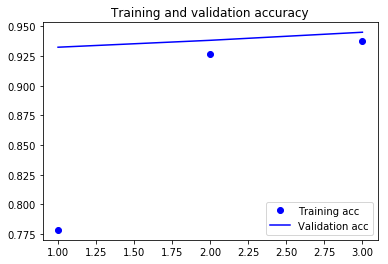

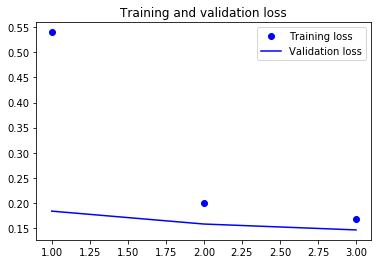

In [4]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

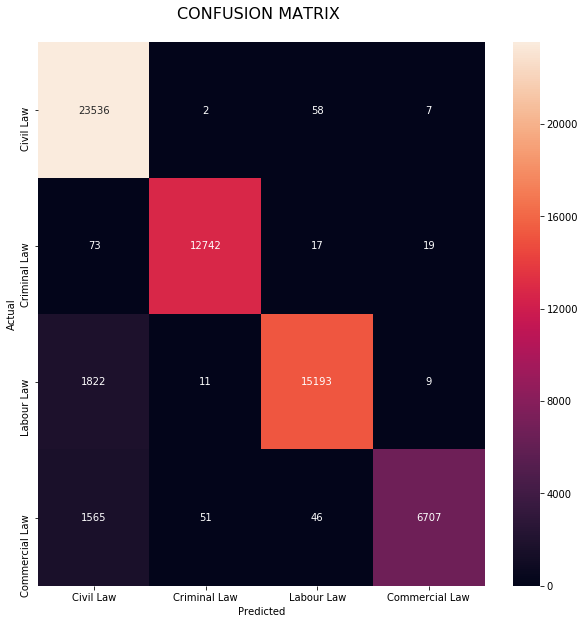

In [12]:
y_pred = model.predict(X_test)
chambres = ["Civil Law", "Criminal Law", "Labour Law", "Commercial Law"]
y_pred = (y_pred > 0.5)
conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=chambres, yticklabels=chambres)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX \n", size=16);
plt.show()